In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
import os
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
from matplotlib.pyplot import get_cmap
import regionmask

In [2]:
fig_dir = '/home/548/cd3022/figures/aus-solar-resource'
os.makedirs(fig_dir, exist_ok=True)

In [3]:
variables = ['num', 'dur', 'freq', 'mean', 'amp']
seasons = ['summer', 'autumn', 'winter', 'spring']
file_path = Path('/g/data/er8/users/cd3022/solar_drought/regional_metrics/')

# Dictionary to hold each variable's DataArray
var_dict = {}

for var in variables:
    season_data = []
    for season in seasons:
        ds = xr.open_dataset(file_path / f'{var}_{season}.nc')
        da = next(iter(ds.data_vars.values()))
        da = da.expand_dims(season=[season])  # Add season as a coordinate
        season_data.append(da)
    var_dict[var] = xr.concat(season_data, dim='season')

# Combine into one Dataset
ds = xr.Dataset(var_dict)

In [4]:
rez_file = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/Indicative REZ boundaries 2024 GIS data.kml'
rez = gpd.read_file(rez_file, engine='pyogrio')
rez = rez.to_crs(epsg=4326)
rez['Name'] = rez['Name'].str[:2]

In [6]:
my_zones = ['Q2', 'Q8', 'N3', 'N5', 'V4', 'V2', 'T1', 'T3', 'S7', 'S8']
my_rez = rez[rez['Name'].isin(my_zones)]

In [21]:
v_vals = {
    'freq': (0,50),
    'amp': (2,12),
    'num': (0,16),
    'dur': (0,10),
    'mean': (5,10)
}

cbar_labels = {
    'freq': 'Number of Days',
    'amp': 'MJ / m2',
    'num': 'Number of Events',
    'dur': 'Number of Days',
    'mean': 'MJ / m2'
}

row_labels = {
    'freq': 'Frequency',
    'amp': 'Amplitude',
    'num': 'Number',
    'dur': 'Duration',
    'mean': 'Mean'
}
col_labels = {
    'summer': 'DJF',
    'autumn': 'MAM',
    'winter': 'JJA',
    'spring': 'SON'
}

In [ ]:
# Start plotting
fig, axes = plt.subplots(
    nrows=len(variables), ncols=len(seasons),
    figsize=(4 * len(seasons), 3 * len(variables)),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

v_vals = {
    'freq': (0,50),
    'amp': (2,12),
    'num': (0,16),
    'dur': (0,10),
    'mean': (5,10)
}

cbar_labels = {
    'freq': 'Number of Days',
    'amp': 'MJ / m2',
    'num': 'Number of Events',
    'dur': 'Number of Days',
    'mean': 'MJ / m2'
}

for i, var in enumerate(variables):
    # Define bin edges for discrete coloring
    da_all = ds[var]
    vmin = v_vals[var][0]
    vmax = v_vals[var][1]
    bins = np.linspace(vmin, vmax, 8)  # 7 bins
    if var in ['mean', 'amp']:
        cmap = get_cmap('plasma', len(bins) - 1)
    else:
        cmap = get_cmap('plasma_r', len(bins) - 1)
    norm = mcolors.BoundaryNorm(bins, ncolors=cmap.N)

    for j, season in enumerate(seasons):
        ax = axes[i, j]
        data = ds[var].sel(season=season) #.squeeze()
        land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(data)
        da_plot = data.where(land_mask == 0)

        if i == 0:
            ax.set_title(season, fontsize=16)
        if j == 0:
            ax.set_ylabel(var, fontsize=16)

        mesh = ax.pcolormesh(
            da_plot['longitude'].values,
            da_plot['latitude'].values,
            da_plot.values,
            cmap=cmap, norm=norm, shading='auto',
            transform=ccrs.PlateCarree()
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])

        # Add REZ shape:
        for geometry in my_rez.geometry:
            ax.add_geometries(
                [geometry],
                crs=ccrs.PlateCarree(),
                facecolor='none',        # or e.g., 'red' with alpha for semi-transparent fill
                edgecolor='green',       # outline color
                linewidth=1.5,
                linestyle='-'           # dashed for visibility
            )

    # Add shared colorbar for this metric (row)
    cbar_ax = fig.add_axes([
        0.92,                     # x-position (pushes cbar to the right)
        0.01 + (len(variables) - i - 1) * 0.2,  # y-position per row
        0.02,                     # width of cbar
        0.18                     # height (matches subplot height)
    ])
    cbar = fig.colorbar(mesh, cax=cbar_ax, ticks=bins, spacing='proportional')
    cbar.ax.set_yticklabels([f'{b:.1f}' for b in bins])
    cbar.set_label(cbar_labels[var])

plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.savefig(f'{fig_dir}metric_map.png')
plt.show()

In [15]:
# Start plotting
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(data)
plot_data = {}
for i, var in enumerate(variables):

    for j, season in enumerate(seasons):

        data = ds[var].sel(season=season) #.squeeze()
        
        key = f'{var}-{season}'
        plot_data[key] = ds[var].sel(season=season).where(land_mask == 0)

In [20]:
ds

<xarray.Dataset> Size: 550MB
Dimensions:    (season: 4, latitude: 1726, longitude: 2214)
Coordinates:
  * season     (season) object 32B 'summer' 'autumn' 'winter' 'spring'
  * latitude   (latitude) float32 7kB -44.5 -44.48 -44.46 ... -10.02 -10.0
  * longitude  (longitude) float32 9kB 112.0 112.0 112.0 ... 156.2 156.2 156.3
Data variables:
    num        (season, latitude, longitude) float64 122MB 0.0 0.0 ... 0.0 0.0
    dur        (season, latitude, longitude) float32 61MB nan nan ... nan nan
    freq       (season, latitude, longitude) float64 122MB 0.0 0.0 ... 0.0 0.0
    mean       (season, latitude, longitude) float64 122MB nan nan ... nan nan
    amp        (season, latitude, longitude) float64 122MB nan nan ... nan nan

/jobfs/145206511.gadi-pbs/ipykernel_2958583/2226793349.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


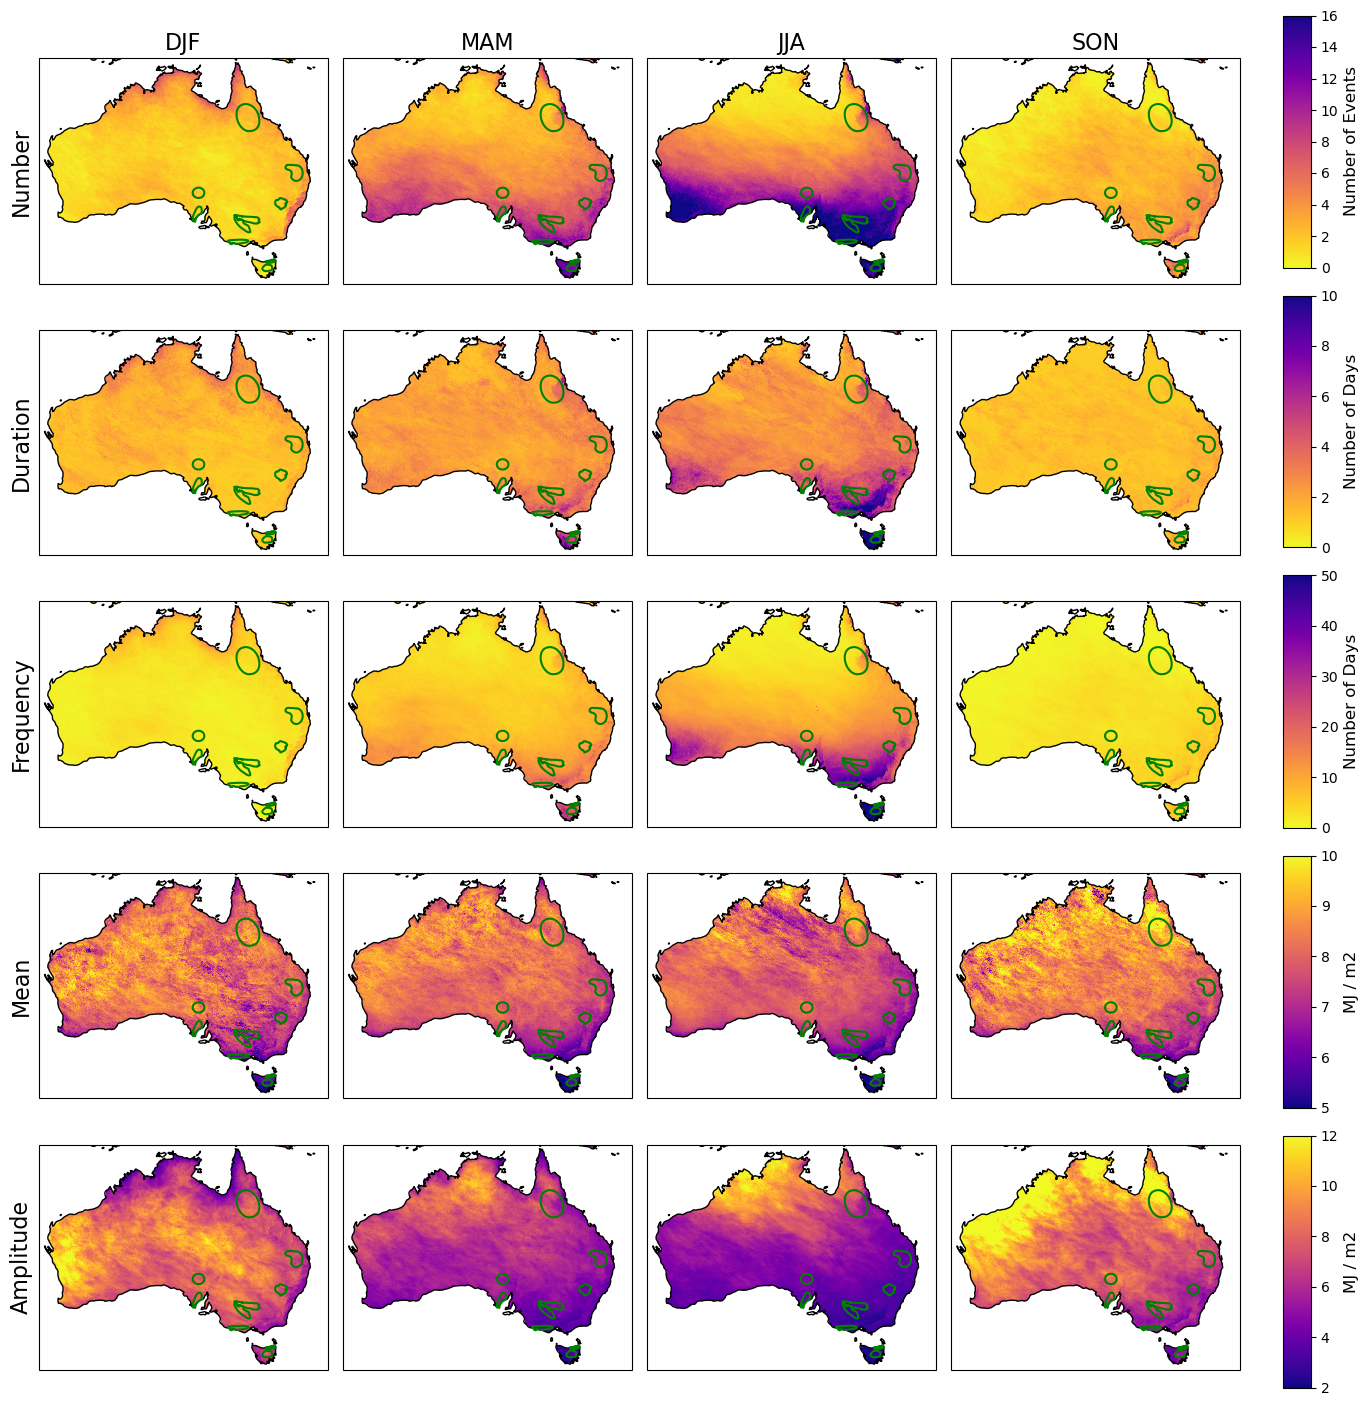

In [28]:
# Start plotting
fig, axes = plt.subplots(
    nrows=len(variables), ncols=len(seasons),
    figsize=(14, 14),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

for i, var in enumerate(variables):
    # Define bin edges for discrete coloring
    vmin = v_vals[var][0]
    vmax = v_vals[var][1]
    if var in ['mean', 'amp']:
        cmap = get_cmap('plasma')
    else:
        cmap = get_cmap('plasma_r')

    for j, season in enumerate(seasons):
        ax = axes[i, j]
        key = f'{var}-{season}'
        da_plot = plot_data[key]

        if i == 0:
            ax.set_title(col_labels[season], fontsize=16)
        if j == 0:
            ax.set_ylabel(row_labels[var], fontsize=16)

        mesh = ax.pcolormesh(
            da_plot['longitude'].values,
            da_plot['latitude'].values,
            da_plot.values,
            cmap=cmap, shading='auto',
            transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmax
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])

        # Add REZ shape:
        for geometry in my_rez.geometry:
            ax.add_geometries(
                [geometry],
                crs=ccrs.PlateCarree(),
                facecolor='none',
                edgecolor='green',
                linewidth=1.5,
                linestyle='-'
            )

    # Add shared colorbar for this metric (row)
    cbar_ax = fig.add_axes([
        0.92,                     # x-position (pushes cbar to the right)
        0.01 + (len(variables) - i - 1) * 0.2,  # y-position per row
        0.02,                     # width of cbar
        0.18                     # height (matches subplot height)
    ])
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    cbar.set_label(cbar_labels[var], fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig(f'{fig_dir}/metric_map.png')
plt.show()